In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import netCDF4
from netCDF4 import Dataset
import cartopy
from pyproj import CRS, Proj, transform, Transformer
import numpy as np
import mapclassify
import pysal
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import string
from matplotlib.collections import PatchCollection

/apps/geopython/1.0.1/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
plt.rcParams.keys()
params = {'axes.labelsize': 30,
          'axes.titlesize': 34,
          'axes.titlepad': 2,
          'xtick.labelsize': 26,
         'ytick.labelsize': 26,
         'legend.title_fontsize':28,
         'legend.fontsize':20}
plt.rcParams.update(params)

In [4]:
states=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_States/cb_2018_us_state_20m.shp')
states=states[(states['NAME']!='Alaska') & (states['NAME']!='Hawaii') & (states['NAME']!='Puerto Rico')]
states=states.to_crs(3857)
states['dissolve']=1
states_as_one_shp=states.dissolve(by='dissolve').reset_index()


counties=gpd.read_file(r'/blue/emullens/meirahwilliamson/Shapefiles/US_Counties/US_Counties.shp')
counties=counties.to_crs(3857)

In [5]:
StormData=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_shapefile_2/StormData.shp')
StormData=StormData.to_crs(3857)

In [6]:
x_latlon=[30,35,40,45]  
y_latlon=[120,105,90,75]
crs_4326=CRS(4326)
crs_proj=CRS(counties.crs)
transformer = Transformer.from_crs(crs_4326,crs_proj)
x_meters,y_meters=transformer.transform(x_latlon, y_latlon)
#why? idk it just works
x_meters=[i * -1 for i in x_meters]

x_latlon_str=['30\N{DEGREE SIGN}N','35\N{DEGREE SIGN}N','40\N{DEGREE SIGN}N','45\N{DEGREE SIGN}N'] 
y_latlon_str=['120\N{DEGREE SIGN}W','105\N{DEGREE SIGN}W','90\N{DEGREE SIGN}W','75\N{DEGREE SIGN}W'] 

In [7]:
#just to get an initial lat lon lineup (yes this is very lazy) (DON'T CHANGE SEASON HERE)
os.chdir(r'/home/meirahwilliamson/blue/netcdf_ero/son')
directory=os.listdir(r'/home/meirahwilliamson/blue/netcdf_ero/son')

for filename in directory:
    ERO_netcdf=xr.open_dataset(filename)
    ERO_c=ERO_netcdf.to_dataframe()
    ERO_c=ERO_c.reset_index()
    
    OBS=ERO_c.keys()[3]
    ERO=ERO_c.keys()[2]
    
    ERO_c=ERO_c.drop([OBS, ERO],axis=1)
        
    break;

### this creates a gdf of missed flash floods

In [9]:
season_list=['jja']

for season in season_list:

    #CHANGE SEASON HERE
    os.chdir(r'/home/meirahwilliamson/blue/netcdf_ero_cleaned/'+season)
    directory=os.listdir(r'/home/meirahwilliamson/blue/netcdf_ero_cleaned/'+season)

    for filename in directory:

        if filename.endswith('.nc'):

            ERO_netcdf=xr.open_dataset(r'grid_stat_ALL_ERO_s2018081512_e2018081612_vhr09_240000L_20180816_120000V_pairs.nc')
            ERO_df=ERO_netcdf.to_dataframe()
            ERO_df=ERO_df.reset_index()

            OBS=ERO_df.keys()[3]
            ERO=ERO_df.keys()[2]

            missed_ff=ERO_df[(ERO_df[OBS] > 0) & (ERO_df[ERO] == 0)][OBS].replace(ERO_df[OBS],1)

            #print(ERO_c.join(missed_ff))

            date=filename[19:27]

            ERO_c['OBS_'+date]=missed_ff
            
            break;


    ERO_gdf = gpd.GeoDataFrame(ERO_c, geometry=gpd.points_from_xy(ERO_c.lon, ERO_c.lat)).fillna(0)
    ERO_gdf['sum']=ERO_gdf.iloc[:,2:].sum(axis=1)
    #ERO_gdf=ERO_gdf.iloc[:,[0,1,-2,-1]]
    ERO_gdf.crs="EPSG:4326"
    ERO_gdf=ERO_gdf.to_crs(3857)
    
    #points_in_states = ERO_gdf[ERO_gdf.geometry.within(states_as_one_shp)]
    
    #points_in_states.to_file(r'/blue/emullens/meirahwilliamson/missed_UFVS/'+season+'_missed_ufvs/'+season+'_missed_ufvs.shp')

In [10]:
ax.set_xticks(x_meters)
ax.set_xticklabels(y_latlon_str)
ax.set_yticks(y_meters)
ax.set_yticklabels(x_latlon_str) 

ERO_gdf_nz=ERO_gdf[ERO_gdf['OBS_20171112']!=0]
ERO_gdf_nz.to_file(r'/blue/emullens/meirahwilliamson/fig2.shp')


NameError: name 'ax' is not defined

<AxesSubplot:>

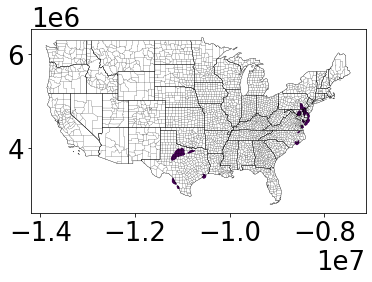

In [39]:
fig2=gpd.read_file(r'/blue/emullens/meirahwilliamson/fig2.shp')
fig,ax=plt.subplots()
fig2.plot(fig2['OBS_201711'],edgecolor="none",markersize=2,ax=ax)
counties.plot(ax=ax,color='none',edgecolor='black',linewidth=0.1,zorder=2)
states.plot(ax=ax,color='none',edgecolor='black',linewidth=0.3,zorder=3)


In [37]:
fig2

,lat,lon,OBS_201711,sum,geometry
0,27.258183,-99.608124,1.0,1.0,POINT (-11088325.618 3155765.440)
1,27.258183,-99.517998,1.0,1.0,POINT (-11078292.833 3155765.440)
2,27.348509,-99.698250,1.0,1.0,POINT (-11098358.403 3167081.205)
3,27.348509,-99.608124,1.0,1.0,POINT (-11088325.618 3167081.205)
4,27.348509,-99.517998,1.0,1.0,POINT (-11078292.833 3167081.205)
...,...,...,...,...,...
622,40.355637,-76.085503,1.0,1.0,POINT (-8469799.409 4917757.807)
623,40.445965,-76.355873,1.0,1.0,POINT (-8499896.913 4930961.888)
624,40.445965,-76.265747,1.0,1.0,POINT (-8489864.129 4930961.888)
625,40.445965,-76.175629,1.0,1.0,POINT (-8479832.194 4930961.888)


### this one creates a gdf of all floods

In [18]:
season_list=['jja','son','mam','djf']

for season in season_list:

    #just to get an initial lat lon lineup (yes this is very lazy) (DON'T CHANGE SEASON HERE)
    os.chdir(r'/blue/emullens/meirahwilliamson/netcdf_ero_cleaned/son/')
    directory=os.listdir(r'/blue/emullens/meirahwilliamson/netcdf_ero_cleaned/son/')

    for filename in directory:
        
        if filename.endswith('.nc'):
            
            ERO_netcdf=xr.open_dataset(filename)
            ERO_c=ERO_netcdf.to_dataframe()
            ERO_c=ERO_c.reset_index()

            OBS=ERO_c.keys()[3]
            ERO=ERO_c.keys()[2]

            ERO_c=ERO_c.drop([OBS, ERO],axis=1)
        
        break;
    
    #CHANGE SEASON HERE
    os.chdir(r'/blue/emullens/meirahwilliamson/netcdf_ero_cleaned/'+season)
    directory=os.listdir(r'/blue/emullens/meirahwilliamson/netcdf_ero_cleaned/'+season)

    for filename in directory:

        if filename.endswith('.nc'):

            ERO_netcdf=xr.open_dataset(filename)
            ERO_df=ERO_netcdf.to_dataframe()
            ERO_df=ERO_df.reset_index()

            OBS=ERO_df.keys()[3]
            ERO=ERO_df.keys()[2]

            ff=ERO_df[(ERO_df[OBS] > 0)][OBS].replace(ERO_df[OBS],1)

            date=filename[19:27]

            ERO_c['OBS_'+date]=ff


    ERO_gdf = gpd.GeoDataFrame(ERO_c, geometry=gpd.points_from_xy(ERO_c.lon, ERO_c.lat)).fillna(0)
    ERO_gdf['sum']=ERO_gdf.iloc[:,2:].sum(axis=1)
    ERO_gdf=ERO_gdf.iloc[:,[0,1,-2,-1]]
    ERO_gdf.crs="EPSG:4326"
    ERO_gdf=ERO_gdf.to_crs(3857)
    
    points_in_states = ERO_gdf[ERO_gdf.geometry.within(states_as_one_shp.geometry.iloc[0])]
            
    points_in_states.to_file(r'/blue/emullens/meirahwilliamson/flash_floods_ufvs/'+season+'_ff/'+season+'_ff.shp')

In [6]:
season_list=['jja','son','mam','djf']
for season in season_list:
    ERO_gdf=gpd.read_file(r'/blue/emullens/meirahwilliamson/flash_floods_ufvs/'+season+'_ff/'+season+'_ff.shp')
    points_in_states = ERO_gdf[ERO_gdf.geometry.within(states_as_one_shp.geometry.iloc[0])]
            
    points_in_states.to_file(r'/blue/emullens/meirahwilliamson/flash_floods_ufvs/'+season+'_ff/'+season+'_ff.shp')

KeyboardInterrupt: 

In [25]:
season_list=['jja','son','mam','djf']

for season in season_list:
    all_=gpd.read_file(r'/blue/emullens/meirahwilliamson/flash_floods_ufvs/'+season+'_ff/'+season+'_ff.shp')
    missed_=gpd.read_file(r'/blue/emullens/meirahwilliamson/missed_UFVS/'+season+'_missed_ufvs/'+season+'_missed_ufvs.shp')
    col=missed_['sum']/all_['sum']
    missed_['pct']=col
    missed_na=missed_.dropna()
    missed_na.to_file(r'/blue/emullens/meirahwilliamson/missed_ufvs_percent/'+season+'/'+season+'.shp')

In [22]:
z=missed_['sum']/all_['sum']
zz=z.dropna()
max(zz)

1.0

In [24]:
len(all_)

101010

In [46]:
ERO_gdf=ERO_gdf.reset_index()

In [54]:
points_in_states = ERO_gdf[ERO_gdf.geometry.within(states_as_one_shp.geometry.iloc[0])]
points_in_states


,index,lat,lon,sum,geometry
546,546,25.000000,-80.591751,0.0,POINT (-8971432.694 2875744.624)
547,547,25.000000,-80.501625,0.0,POINT (-8961399.910 2875744.624)
1268,1268,25.090328,-80.501625,0.0,POINT (-8961399.910 2886843.495)
1982,1982,25.180655,-81.132500,0.0,POINT (-9031628.553 2897950.327)
1983,1983,25.180655,-81.042374,0.0,POINT (-9021595.768 2897950.327)
...,...,...,...,...,...
193616,193616,49.207710,-94.831497,1.0,POINT (-10556593.979 6310179.253)
194334,194334,49.298035,-95.101875,1.0,POINT (-10586692.332 6325583.780)
194335,194335,49.298035,-95.011749,1.0,POINT (-10576659.548 6325583.780)
194336,194336,49.298035,-94.921623,1.0,POINT (-10566626.763 6325583.780)


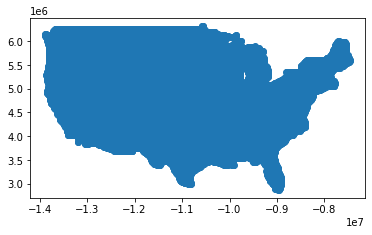

In [55]:
points_in_states.plot()

### this looks at damaged counties

In [18]:
df=gpd.GeoDataFrame(columns=StormData.keys())
df

,GEOID,NAME,Shape_Leng,Shape_Area,Unnamed_ 0,date,property_d,month,flood_caus,season,episode_id,episode_na,geometry


In [50]:
season_list=['jja','son','mam','djf']
i=0

for season in season_list:

    #CHANGE SEASON HERE
    os.chdir(r'/home/meirahwilliamson/blue/netcdf_ero_cleaned/'+season)
    directory=os.listdir(r'/home/meirahwilliamson/blue/netcdf_ero_cleaned/'+season)

    for filename in directory:

        if filename.endswith('.nc'):

            ERO_netcdf=xr.open_dataset(filename)
            ERO_df=ERO_netcdf.to_dataframe()
            ERO_df=ERO_df.reset_index()

            OBS=ERO_df.keys()[3]
            ERO=ERO_df.keys()[2]

            missed_ff=ERO_df[(ERO_df[OBS] > 0) & (ERO_df[ERO] == 0)][OBS].replace(ERO_df[OBS],1)

            #print(ERO_c.join(missed_ff))
            
            date=filename[19:27]

            ERO_c['OBS_'+date]=missed_ff
            
            ERO_1=ERO_c[ERO_c['OBS_'+date]>0]

            #just to check progress
            i+=1
            if i % 50 ==0:
                print(i)
            
            ERO_gdf = gpd.GeoDataFrame(ERO_1, geometry=gpd.points_from_xy(ERO_1.lon, ERO_1.lat)).fillna(0)
            ERO_gdf.crs="EPSG:4326"
            ERO_gdf=ERO_gdf.to_crs(3857)

            StormData_date=StormData[StormData['date']==int(date)]
            
            if StormData_date.empty==False:

                StormData_missed_ff=gpd.sjoin(StormData_date,ERO_gdf,how='inner')
                StormData_missed_ff=StormData_missed_ff.drop_duplicates(subset='GEOID',keep='first')
                StormData_missed_ff=StormData_missed_ff.drop(columns=StormData_missed_ff.columns[-4:])

                df=df.append(StormData_missed_ff)
            
            
            ERO_c=ERO_c.drop(columns=['OBS_'+date])
            

In [29]:
df.to_file(r'/home/meirahwilliamson/blue/missed_StormData/missed_individual/missed_individual.shp')

In [ ]:
df=gpd.read_file(r'/home/meirahwilliamson/blue/missed_StormData/missed_individual_RFC/missed_individual_RFC.shp')
df

In [2]:
# use missed individual file (df)

StormData=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_RFC/StormData.shp')
StormData=StormData.to_crs(3857)

season_list=['jja','son','mam','djf']

for season in season_list:
    all_season=StormData[StormData['season']==season].loc[:,['GEOID','property_d']].groupby(['GEOID'])['property_d'].sum().reset_index()
    
    print(all_season)
    
    grouped=df.groupby(['season','GEOID'])['property_d'].sum().reset_index()
    grouped_count=df.groupby(['season','GEOID']).count().reset_index()
    
    grouped_season=grouped[grouped['season']==season]                            # really just need a count (can choose any var in place of NAME)
    grouped_count_season=grouped_count[grouped_count['season']==season].loc[:,['GEOID','NAME']]
    grouped_count_season=grouped_count_season.rename(columns={'NAME':'count'})

    merge_all_grouped=all_season.merge(grouped_season,on="GEOID",how='left')
    merge_all_grouped=merge_all_grouped.merge(grouped_count_season,on="GEOID", how='left')
    
    merge_all_grouped=merge_all_grouped.fillna(0)
    merge_all_grouped['pct_damage']=merge_all_grouped['property_d_y']/merge_all_grouped['property_d_x']
    counties_merge=counties.merge(merge_all_grouped,on='GEOID',how='left')
    #counties_merge.to_file(r'/blue/emullens/meirahwilliamson/missed_StormData/missed_damaged_total/'+season+'/'+season+'.shp')

     GEOID  property_d
0    01025     50000.0
1    01097     30000.0
2    01129    500000.0
3    04003    126000.0
4    04005    100000.0
..     ...         ...
821  55127  10001000.0
822  55131    584000.0
823  55133      5000.0
824  56013     75000.0
825  56045     25000.0

[826 rows x 2 columns]


NameError: name 'df' is not defined

In [6]:
StormData

,GEOID,NAME,Shape_Leng,Shape_Area,Unnamed_ 0,date,property_d,month,flood_caus,season,episode_id,episode_na,index_righ,SITE_ID,STATE,RFC_NAME,RFC_CITY,BASIN_ID,geometry
0,37017,Bladen,2.071393,0.223971,110.0,20161008.0,4950000.0,10.0,Heavy Rain / Tropical System,son,110904.0,Major Hurricane Matthew moved up the southeast...,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-8783330.240 4141517.196, -8771931.0..."
1,37017,Bladen,2.071393,0.223971,1751.0,20180915.0,70000.0,9.0,Heavy Rain / Tropical System,son,130719.0,Hurricane Florence began its long Atlantic tre...,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-8783330.240 4141517.196, -8771931.0..."
2,37017,Bladen,2.071393,0.223971,1761.0,20180916.0,170000.0,9.0,Heavy Rain / Tropical System,son,130719.0,Hurricane Florence began its long Atlantic tre...,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-8783330.240 4141517.196, -8771931.0..."
3,37167,Stanly,1.413707,0.104023,NaN,NaN,NaN,NaN,None,None,NaN,None,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-8960926.795 4191380.301, -8938445.3..."
4,39153,Summit,1.484157,0.117675,2400.0,20190616.0,3750000.0,6.0,Heavy Rain,jja,139516.0,A stationary front supported widespread shower...,10.0,TIR,OH,Ohio,Cincinatti,OHRFC,"POLYGON ((-9093354.131 5032415.872, -9093127.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5345,37023,Burke,1.733294,0.132195,2367.0,20190608.0,50000.0,6.0,Heavy Rain,jja,139648.0,A moist upslope flow developing north of a sta...,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-9117806.793 4284585.933, -9121873.9..."
5346,37023,Burke,1.733294,0.132195,2376.0,20190609.0,2000.0,6.0,Heavy Rain,jja,139648.0,A moist upslope flow developing north of a sta...,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-9117806.793 4284585.933, -9121873.9..."
5347,37023,Burke,1.733294,0.132195,3004.0,20200206.0,25000.0,2.0,Heavy Rain,djf,145216.0,Unusually high levels of moisture for early Fe...,11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-9117806.793 4284585.933, -9121873.9..."
5348,37023,Burke,1.733294,0.132195,3120.0,20200412.0,1000.0,4.0,Heavy Rain,mam,147364.0,"A strong storm system impacted the Southeast, ...",11.0,ALR,GA,Southeast,Atlanta,SERFC,"POLYGON ((-9117806.793 4284585.933, -9121873.9..."


43
43
43
43


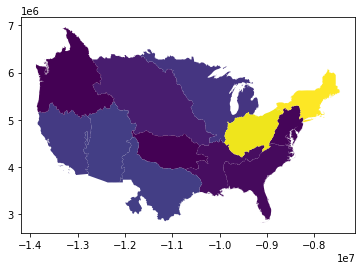

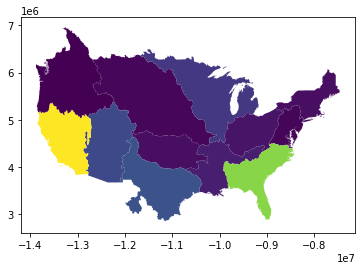

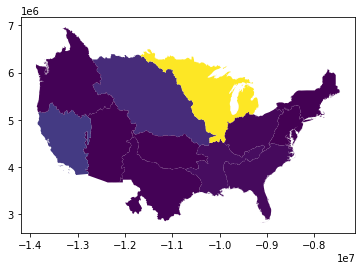

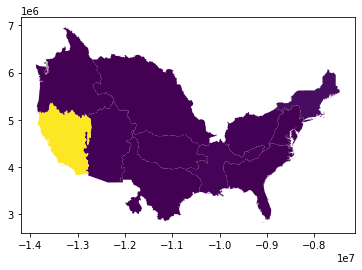

In [12]:
# use missed individual file (df)
river=gpd.read_file(r'/blue/emullens/meirahwilliamson/rf12ja05/rf12ja05.shp')
river=river.to_crs(epsg=3857)

StormData=gpd.read_file(r'/blue/emullens/meirahwilliamson/StormData_RFC/StormData.shp')
StormData=StormData.to_crs(3857)

season_list=['jja','son','mam','djf']

for season in season_list:
    all_season=StormData[StormData['season']==season].groupby(['BASIN_ID']).agg({'property_d':'sum', 'episode_na':'first','GEOID':'first','date':'first','flood_caus':'first'}).reset_index()
    
    grouped=df.groupby(['season','BASIN_ID'])['property_d'].sum().reset_index()
    grouped_count=df.groupby(['season','BASIN_ID']).count().reset_index()
    print(len(grouped_count))
    
    grouped_season=grouped[grouped['season']==season]                            # really just need a count (can choose any var in place of NAME)
    grouped_count_season=grouped_count[grouped_count['season']==season].loc[:,['BASIN_ID','NAME']]
    grouped_count_season=grouped_count_season.rename(columns={'NAME':'count'})

    merge_all_grouped=all_season.merge(grouped_season,on="BASIN_ID",how='left')
    merge_all_grouped=merge_all_grouped.merge(grouped_count_season,on="BASIN_ID", how='left')
    
    merge_all_grouped=merge_all_grouped.fillna(0)
    merge_all_grouped['pct_damage']=merge_all_grouped['property_d_y']/merge_all_grouped['property_d_x']
    river_merge=river.merge(merge_all_grouped,on='BASIN_ID',how='left')
    #print(counties_merge)
    #river_merge.to_file(r'/blue/emullens/meirahwilliamson/missed_StormData/missed_damaged_total_RFC/'+season+'/'+season+'.shp')
    river_merge.plot('property_d_y')
    
    